## Logistics

We are going to use parallel-tempering, implemented via the python emcee package, to explore our posterior, which consists of the set of distances and gas to dust conversion coefficients to the six velocity slices towards the center of the Cepheus molecular cloud. Since we need to explore a 12 dimensional parameter space, we are going to use 50 walkers, 10000 steps each, at 5 different temperatures. If you would like to edit this parameters, simply edit "nwalkers", "ntemps", and "nsteps" in the cell below. However, we are only going to keep the lowest temperature chain ($\beta=1$) for analysis. Since the sampler.chain object from PTSampler returns an array of shape (Ntemps, Nwalkers, Nsteps, Ndim), returning the samples for all walkers, steps, and dimensions at $\beta=1$ would correspond to sampler.chain[0,:,:,:]. To decrease your value of $\beta$ simply increase the index for the first dimension. For more information on how PTSampler works, see http://dan.iel.fm/emcee/current/user/pt/. We will set off our walkers in a Gaussian ball around a) the kinematic distance estimates for the Cepheus molecular cloud given by a flat rotation curve from Leroy & Rosolowsky 2006 and b) the gas-to-dust coefficient given by the literature. We perturb the walkers in a Gaussian ball with mean 0 and variance 1. You can edit the starting positions of the walkers by editing the "result" variable below. We are going to discard the first half of every walker's chain as burn-in. 

### Setting up the positional arguments for PTSampler

We need to feed PTSampler the required positional arguments for the log_likelihood and log_prior function. We do this using the fetch_args function from the io module, which creates an instance of the pixclass object that holds our data and metadata. Fetch_args accepts three arguments: 

- A string specifiying the h5 filenames containing your data, in our case 10 healpix nside 128 pixels centered around (l,b)=(109.75, 13.75), which covers a total area of 2 sq. deg. 
- The prior bounds you want to impose on distances (flat prior) and the standard deviation you'd like for the log-normal prior on the conversion coefficients. For distances, this must be between 4 and 19, because that's the distance modulus range of our stellar posterior array. The prior bounds must be in the format [lowerbound_distance, upperbound_distance, sigma]
- The gas-to-dust coefficient you'd like to use, given as a float; for this tutorial, we are pulling a value from the literature of 0.06 magnitudes/K. This value is then multiplied by the set of c coefficients we're determining as part of the parameter estimation problem. 

Fetch_args will then return the correct arguments for the log_likelihood and log_prior functions within the model module. 

Here we go!

The sampler is done running, so now let's check out the results. We are going to print out our mean acceptance fraction across all walkers for the coldest temperature chain. 

We are also going to discard the first half of each walker's chain as burn-in; to change the number of steps to burn off, simply edit the 3rd dimension of sampler.chain[0,:,n:,:] and input your desired value of n. Next, we are going to compute and print out the 50th, 16th, and 84th percentile of the chains for each distance parameter, using the "quantile" attribute of a pandas dataframe object. The 50th percentile measurement represents are best guess for the each distance parameter, while the difference between the 16th and 50th gives us a lower limit and the difference between the 50th and 84th percentile gives us an upper limit:

In [1]:
import emcee
from dustcurve import model
import seaborn as sns
import numpy as np
from dustcurve import pixclass
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from dustcurve import io
from dustcurve import hputils
from dustcurve import kdist
import h5py
from dustcurve import globalvars as gv
%matplotlib inline

f=h5py.File('/n/fink1/czucker/Output/2degrees_jul1_0.1sig_cropped.h5')
samples=f['/chains']

nsteps=samples.shape[2]
ndim=samples.shape[3]

#Extract the coldest [beta=1] temperature chain from the sampler object; discard first half of samples as burnin
samples_cold = samples[0,:,int(.5*nsteps):,:]
traces_cold = samples_cold.reshape(-1, ndim).T

#find best fit values for each of the 24 parameters (12 d's and 12 c's)
theta=pd.DataFrame(traces_cold)
quantile_50=theta.quantile(.50, axis=1).values
quantile_84=theta.quantile(.84, axis=1).values
quantile_16=theta.quantile(.16, axis=1).values

upperlim=quantile_84-quantile_50
lowerlim=quantile_50-quantile_16

#print out distances
for i in range(0,int(len(quantile_50)/2)):
    print('d%i: %.3f + %.3f - %.3f' % (i+1,quantile_50[i],upperlim[i], lowerlim[i]))

#print out coefficients
for i in range(int(len(quantile_50)/2), int(len(quantile_50))):
    print('c%i: %.3f + %.3f - %.3f' % (i+1-int(len(quantile_50)/2),quantile_50[i],upperlim[i], lowerlim[i]))


/n/home12/czucker/envs/PYTHON3/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


d1: 9.818 + 0.017 - 0.143
d2: 14.528 + 0.061 - 7.128
d3: 14.672 + 0.185 - 9.693
d4: 4.465 + 1.243 - 0.234
d5: 14.505 + 1.598 - 0.125
d6: 7.733 + 0.052 - 0.042
c1: 5.416 + 0.021 - 0.141
c2: 3.593 + 0.053 - 3.218
c3: 1.294 + 0.046 - 0.850
c4: 3.812 + 0.110 - 1.629
c5: 1.420 + 0.114 - 0.436
c6: 9.976 + 0.019 - 0.583


Let's see what our chains look like by producing trace plots:

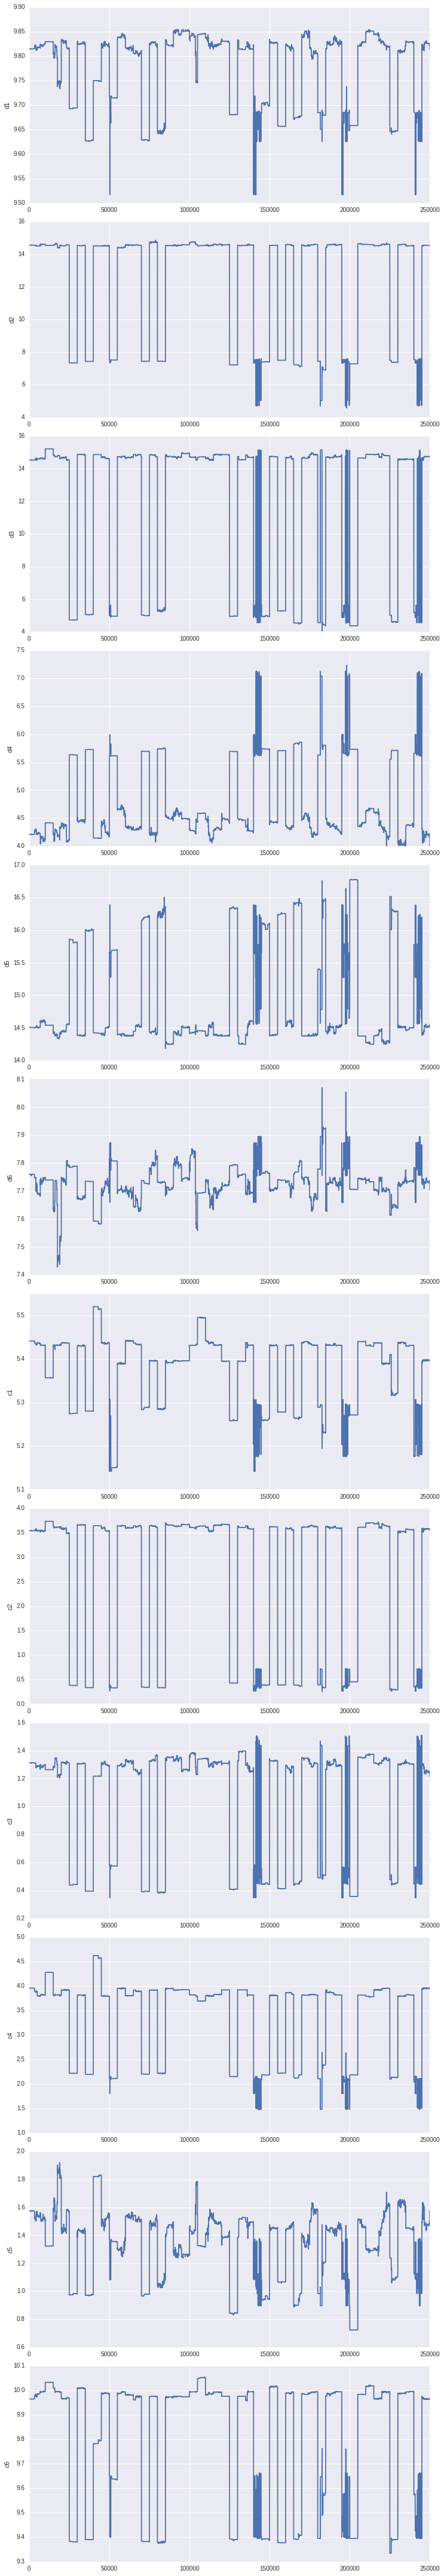

In [5]:
#set up subplots for chain plotting
axes=['ax'+str(i) for i in range(ndim)]
fig, (axes) = plt.subplots(ndim, figsize=(10,60))

plt.tight_layout()

for i in range(0,ndim):
    if i<int(ndim/2):
        axes[i].set(ylabel='d%i' % (i+1))
    else:
        axes[i].set(ylabel='c%i' % (i-5))

#plot traces for each parameter
for i in range(0,ndim):
    sns.tsplot(traces_cold[i],ax=axes[i])


Now we are going to use the seaborn distplot function to plot histograms of the last half of the traces for each parameter. 

/n/home12/czucker/envs/PYTHON3/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


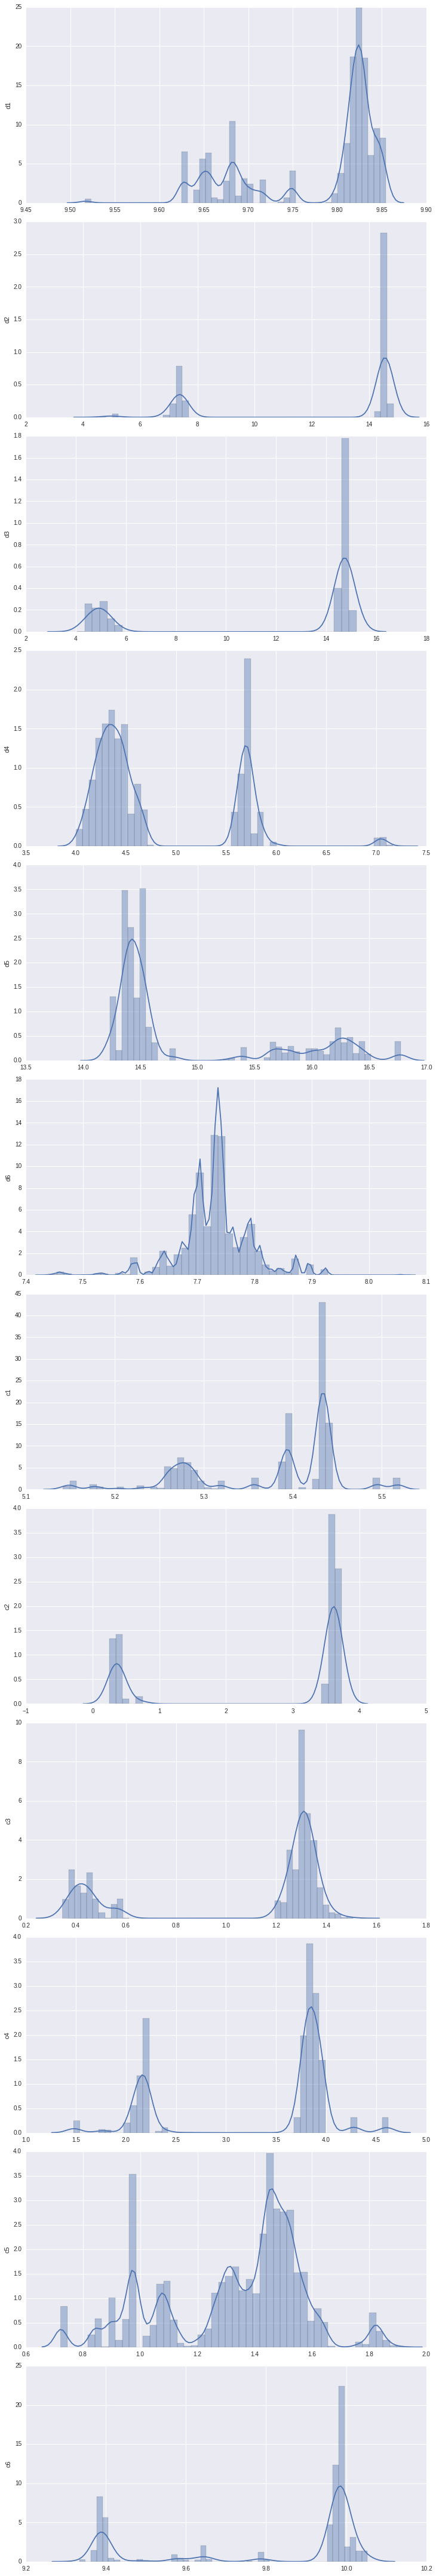

In [6]:
#set up subplots for histogram plotting
axes=['ax'+str(i) for i in range(ndim)]
fig, (axes) = plt.subplots(ndim, figsize=(10,60))

plt.tight_layout()

for i in range(0,ndim):
    if i<int(ndim/2):
        axes[i].set(ylabel='d%i' % (i+1))
    else:
        axes[i].set(ylabel='c%i' % (i-5))

#plot traces for each parameter
for i in range(0,ndim):
    sns.distplot(traces_cold[i],ax=axes[i],hist=True,norm_hist=False)


Now we want to see how similar the parameters at different steps are. To do this, we draw one thousand random samples from the last half of the chain and plot the reddening profile corresponding to those parameters in light blue. Then, we plot the "best fit" reddening profile corresponding to the 50th quantile parameters (essentially the median of the last half of the chains). In all cases, we take the average of the CO for all nside 128 pixels at each slice. As you can see, drawing random samples from the last half of the chain produce reddening profiles essentially identical to the best fit values. 

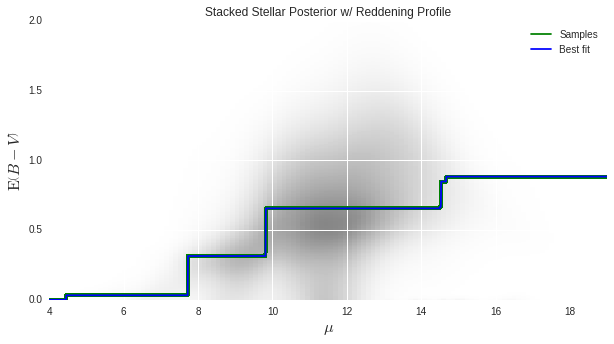

In [3]:
from dustcurve import plot_posterior

ratio=0.06
plot_posterior.plot_samples(np.asarray(post_all),np.linspace(4,19,120),np.linspace(0,7,700),quantile_50,traces_cold,ratio,gv.unique_co,y_range=[0,2],vmax=20,normcol=False)